# TASK: 02
# Object Detection System using Ultralytics
## YOLOv8 with Custom MobileNet Backbone
In this task, I am going to train a YOLOv8 model on the __Personal Protective Equipments Dataset__ with custom __MobileNet__ backbone.

## Configuring the Development Environment
We need to install __ultralytics__ so that we can use the YOLO framework and its models.

In [ ]:
!pip install --quiet ultralytics

In [ ]:
# While working on kaggle, the ultralytics training utility requires
# to login into the Weights & Biases account, so here I am doing that
import wandb


# Replace 'YOUR_WANDB_API_KEY' with your actual API key
api_key = "6c17bea554b89bcf3f79aeac218d7a9216689106"

# Login to Weights & Biases using your API key
wandb.login(key=api_key)

## Dataset
We will use the FER2013 Dataset which contains __10__ classes, as listed below:
1. Hardhat
2. Mask
3. NO-Hardhat
4. NO-Mask
5. NO-Safety Vest
6. Person
7. Safety Cone
8. Safety Vest
9. machinery
10. vehicle

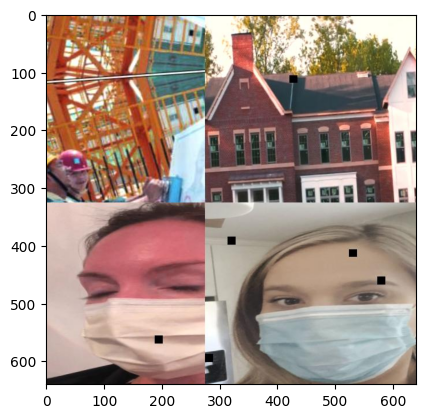

In [ ]:
# verifying that the datset
import matplotlib.pyplot as plt
from matplotlib.image import imread


image = imread('path_to_an_image_in_the_dataset')
plt.imshow(image)
plt.show()

## Cloning Ultralytics GitHub Repo
We need to clone the Ultralytics GitHub Repository, so that we can make custom changes to the architecture.

In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git
%cd ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 30605, done.
remote: Counting objects: 100% (1061/1061), done.
remote: Compressing objects: 100% (698/698), done.
remote: Total 30605 (delta 665), reused 641 (delta 359), pack-reused 29544
Receiving objects: 100% (30605/30605), 15.82 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (21951/21951), done.
/content/ultralytics


## Dataset Configuration File
In order for the YOLOv8 model to train on our data, we need to provide it with a .yaml file. In this file we need to specify the paths to the __train__ and __val__ images, number of classes, and the labels as well.

In [ ]:
with open('data.yaml', 'w') as file:
    file.write('''
train: /content/css-data/train
val: /content/css-data/valid

nc: 10
names: [Hardhat, Mask, NO-Hardhat, NO-Mask, NO-Safety Vest, Person, Safety Cone, Safety Vest, machinery, vehicle]
    ''')

### MobileNet Backbone
Let's create a custom __MobileNet__ backbone:

We need to define a .yaml file for the backbone, describing the various elements (convolutional layers, bottleneck layers, etc) in the model. In the model configuration, we are only changing the backbone, the head remains the same.

In [ ]:
with open('yolov8-mobilenet.yaml', 'w') as file:
    file.write('''
nc: 80  # number of classes
scales:
  l: [1.00, 1.00, 512]
  x: [1.00, 1.25, 512]

backbone:
  # [from, repeats, module, args]
  - [-1, 1, ResNetLayer, [3, 64, 1, True, 1]]  # 0-P1/2
  - [-1, 1, ResNetLayer, [64, 64, 1, False, 3]]  # 1-P2/4
  - [-1, 1, ResNetLayer, [256, 128, 2, False, 4]]  # 2-P3/8
  - [-1, 1, ResNetLayer, [512, 256, 2, False, 6]]  # 3-P4/16
  - [-1, 1, ResNetLayer, [1024, 512, 2, False, 3]]  # 4-P5/32

# Transition layers
  - [-1, 1, Conv, [512, 1, 1]]  # 5: Adjust channels for P5
  - [3, 1, Conv, [256, 1, 1]]   # 6: Adjust channels for P4
  - [2, 1, Conv, [128, 1, 1]]   # 7: Adjust channels for P3

head:
  - [5, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]  # cat adjusted P4
  - [-1, 3, C2f, [512]]  # 10
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 7], 1, Concat, [1]]  # cat adjusted P3
  - [-1, 3, C2f, [256]]  # 13 (P3/8-small)
  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 10], 1, Concat, [1]]  # cat head P4
  - [-1, 3, C2f, [512]]  # 16 (P4/16-medium)
  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 5], 1, Concat, [1]]  # cat adjusted P5
  - [-1, 3, C2f, [1024]]  # 19 (P5/32-large)
  - [[13, 16, 19], 1, OBB, [nc, 1]]  # Detect(P3, P4, P5)
''')

## Training with MobileNet Backbone
I am training the YOLOv8 with MobileNet backbone for __100 Epochs__ using Kaggle GPUs.

In [ ]:
from ultralytics import YOLO


# model = YOLO('yolov8-mobilenet.yaml')
# results = model.train(
#     data='data.yaml',
#     epochs=100,
#     imgsz=640,
#     save=True,
#     save_period=5,
#     name='ppe_detection_mobilenet',
#     device=[0, 1],
# )

### Training results
Somehow, I lost the output of the cell which shows different epochs of training. but I have created a plot to show the results of training. We can see that how various metrics are changing through out the process. To see the full training results, you can see __YOLOv8_MobileNet Directory__.
![YOLOv8 MobileNet Training Results](YOLOv8_MobileNet\results.png)